# Understanding .grad
I'm going to create a tensor x, define y to be the cosine of x, and show how to get autograd to give me minus the sine of x, since that is the derivative of y with respect to x. 

A point I missed for a while is that the expected result ends up in an unexpected (to me) place; it goes in  x.grad, not y.grad. 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Pytorch tutorial that works...
Ok, the following example works. How is it different from mine? 
https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

In [2]:
import torch
abshape = (2,7)
a = torch.randn(abshape, requires_grad=True)
b = torch.randn(abshape, requires_grad=True)

I added the following so that I could run this section multiple times; otherwise gradients accumulate. 

In [3]:
a.grad = None
b.grad = None

In [4]:
Q = 3*a**3 - b**2

Here is the explanation of the "external" argument to backward():
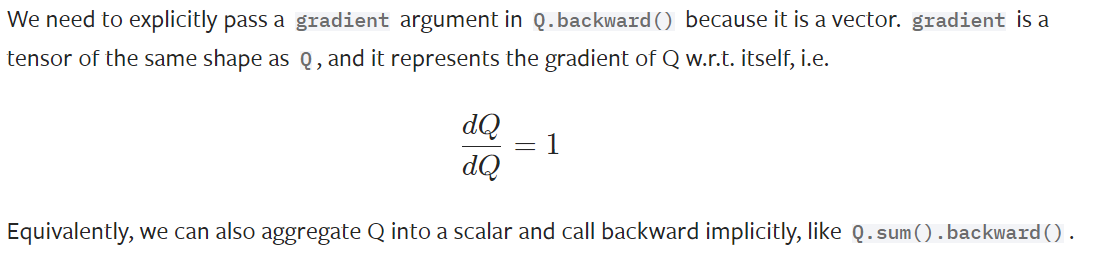

I think by "because it is a vector", they mean "because Q is a vector". 

In [5]:
external_grad = torch.ones_like(a)
Q.backward(gradient=external_grad)

In [6]:
# check if collected gradients are correct
print(torch.all(torch.isclose(9*a**2, a.grad)).item())
print(torch.all(torch.isclose(-2*b, b.grad)).item())

True
True


## Ok fine, cosine and sine....

In [7]:
x = torch.linspace(0,2*np.pi,1000, requires_grad=True)

In [8]:
y = torch.cos(x)   

In [9]:
x.grad = None # so we can run multiple times. Otherwise x.grad accumulates.

external_grad = torch.ones_like(x) # grad is proportional to this? I do not get it. 
y.backward(gradient=external_grad, retain_graph=True, inputs=x)

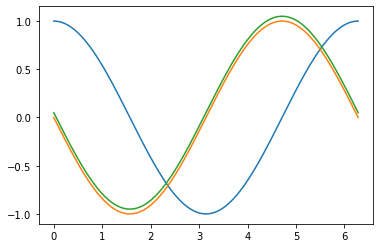

In [10]:
xp = x.detach()
yp = y.detach()
plt.plot(xp, yp, xp, x.grad, xp, -torch.sin(x).detach()+0.05)

In [11]:
torch.sum(torch.abs(x.grad+torch.sin(x)))

tensor(0., grad_fn=<SumBackward0>)

## Use backward() to get gradient of 1/2 the square of a linear function and make sure I understand it

In [114]:
from torch import nn
# your simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        '''Forward pass'''
#         return self.layers(x)
        return self.layers(x)

    


In [116]:
out_dim, in_dim = 4,3
mlp = SimpleMLP(in_dim, out_dim)

xin = torch.rand(in_dim)
xpred = mlp(xin)
xgt = torch.rand_like(xpred)

In [117]:
ssq = (0.5*(xpred-xgt)**2).sum()

In [118]:
ssq.backward()

In [119]:
for n,p in mlp.named_parameters():
    print(n+'.grad', p.grad)

layers.weight.grad tensor([[ 0.0793,  0.1306,  0.0550],
        [ 0.1107,  0.1823,  0.0768],
        [ 0.0322,  0.0531,  0.0224],
        [-0.0705, -0.1162, -0.0489]])
layers.bias.grad tensor([ 0.2489,  0.3474,  0.1012, -0.2214])


In [120]:
xpred-xgt

tensor([ 0.2489,  0.3474,  0.1012, -0.2214], grad_fn=<SubBackward0>)

In [122]:
(xpred-xgt).reshape(out_dim,1)@xin.reshape(1,in_dim)

tensor([[ 0.0793,  0.1306,  0.0550],
        [ 0.1107,  0.1823,  0.0768],
        [ 0.0322,  0.0531,  0.0224],
        [-0.0705, -0.1162, -0.0489]], grad_fn=<MmBackward>)

In [123]:
  
def sigmoid(x):
    return 1 /(1+torch.exp(-x))

def sigprime(x):
    return torch.exp(-x)*sigmoid(x)**2

def invsigmoid(x):
    return -torch.log(1/x-1)


Here's one I checked in math: sigmoid of a linear transformation. 

\begin{align}
  & \mathbf{Y}=\sigma \left( \mathbf{W}\cdot \mathbf{X}+\mathbf{B} \right) \\ 
 & {{Y}_{i}}=\sigma \left( \sum\limits_{j}{{{W}_{ij}}{{X}_{j}}+{{B}_{i}}} \right)\equiv \sigma \left( {{Z}_{i}} \right) \\ 
 & \frac{\partial {{Y}_{i}}}{\partial {{W}_{kl}}}={\sigma }'\left( {{Z}_{i}} \right)\frac{\partial {{Z}_{i}}}{\partial {{W}_{kl}}}={\sigma }'\left( {{Z}_{i}} \right)\sum\limits_{j}{\frac{\partial {{W}_{ij}}}{\partial {{W}_{kl}}}{{X}_{j}}} \\ 
 & ={\sigma }'\left( {{Z}_{i}} \right)\sum\limits_{j}{{{\delta }_{ik}}{{\delta }_{jl}}{{X}_{j}}} \\ 
 & \frac{\partial {{Y}_{i}}}{\partial {{W}_{kl}}}={\sigma }'\left( {{Z}_{i}} \right){{X}_{l}}{{\delta }_{ik}} \\ 
 & \frac{\partial {{Y}_{i}}}{\partial {{B}_{k}}}={\sigma }'\left( {{Z}_{i}} \right)\frac{\partial {{B}_{i}}}{\partial {{B}_{k}}}={\sigma }'\left( {{Z}_{i}} \right){{\delta }_{ik}} \\ 
\end{align}


So this last expression is the Jacobian. What usually happens is we sum over output components before calling backward(), i.e. we do a sum over i first, which I guess amounts to a sum over rows of the Jacobian. (It is confusing because there are three indices, but I think effectively k and l are a single 1D index. The sigmoid of Z has the same shape as Z, which is the same as the shape of Y. That is why I have written it component-wise the way I did: the ith component of Y is just the sigmoid of the ith component of Z.) 

The math here is different from that "summing before calling backward()" thing. Here I have instead differentiated first, and I will sum over the outputs afterward. That should be the same thing since differentiation is a linear operation. But I am having trouble figuring out how to get autograd to hold off on summing. 

In [133]:
sigl = sigmoid(mlp(xin))
for p in mlp.parameters():
    p.grad = None
sigl.sum().backward()  # this sums over the outputs, of which there are out_dim. 

In [134]:
for n,p in mlp.named_parameters():
    print(n+'.grad', p.grad)

layers.weight.grad tensor([[0.0775, 0.1277, 0.0538],
        [0.0734, 0.1210, 0.0510],
        [0.0792, 0.1305, 0.0550],
        [0.0776, 0.1278, 0.0538]])
layers.bias.grad tensor([0.2434, 0.2305, 0.2487, 0.2435])


The following is an outer product of two vectors, yielding a matrix. The prediction has out_dim components, while the input has in_dim of course. The resulting matrix hold the components of the gradient with respect to the weights, which show up in the grad attributes of the paramters of mlp. 

In [135]:
sigprime(xpred).reshape(out_dim,1) @ xin.reshape(1,in_dim)

tensor([[0.0775, 0.1277, 0.0538],
        [0.0734, 0.1210, 0.0510],
        [0.0792, 0.1305, 0.0550],
        [0.0776, 0.1278, 0.0538]], grad_fn=<MmBackward>)

In [136]:
sigprime(mlp(xin))

tensor([0.2434, 0.2305, 0.2487, 0.2435], grad_fn=<MulBackward0>)

In the above I took the sum before calling backward. I can also specify to backward how it should sum. I THINK I CAN, BUT NOT YET, SHEESH. HOW DOES THIS WORK?

In [ ]:

# Following are utilities to make nn.Module "functional", in the sense of 
#    being from or compatible with the torch.autograd.functional library. 
#
# borrowed from the link I posted in comment
def del_attr(obj, namesplit): # why, why, why? But it definitely breaks without this. 
    if len(namesplit) == 1:
        delattr(obj, namesplit[0])
    else:
        del_attr(getattr(obj, namesplit[0]), namesplit[1:])

def set_attr(obj, namesplit, val):
    if len(namesplit) == 1:
        setattr(obj, namesplit[0], val)
    else:
        set_attr(getattr(obj, namesplit[0]), namesplit[1:], val)

def make_functional(model):
    orig_params = tuple(model.parameters())
    orig_grad = capture_gradients(model)
    # Remove all the parameters in the model, because reasons. 
    names = []
    for name, p in list(model.named_parameters()):
        del_attr(model, name.split("."))
        names.append(name)
    return orig_params, orig_grad, names
